# Tarea de Clustering

## Introducción
Esta tarea consiste en la implementación en python del algoritmo de k-means desde cero, tomando en cuenta las siguientes características:
<ol>
    <li>
        <strong>Comparación de implementaciones de k-means:</strong> Se ha realizado una comparación de los resultados obtenidos con el algoritmo implementado desde cero y el algoritmo que ofrece la librería <a href="https://scikit-learn.org/stable/">sickit-learn</a>.
    </li>
    <li>
        <strong>Comparación de algoritmos:</strong> Se ha realizado una comparación de resultados entre los algoritmos k-medoids y k-means.
    </li>
    <li>
        <strong>Uso de clustering jerárquico</strong>
    </li>
    <li>
        <strong>Evaluación del rendimiento:</strong> Se ha utilizado la silueta para evaluar el rendimiento de todos los métodos.
    </li>    
</ol>

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias y carga de datos

In [245]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering

In [246]:
# Loading the data
data = pd.read_csv('data.csv')
#data.drop(columns='color', inplace=True)
# Displaying the first 5 rows of the data
data.head(5)

,x,y,color
0,516.012706,393.014514,0
1,436.211762,408.656585,0
2,512.052601,372.022014,0
3,489.140464,401.807159,0
4,446.207986,338.516682,0


### Visualización de datos

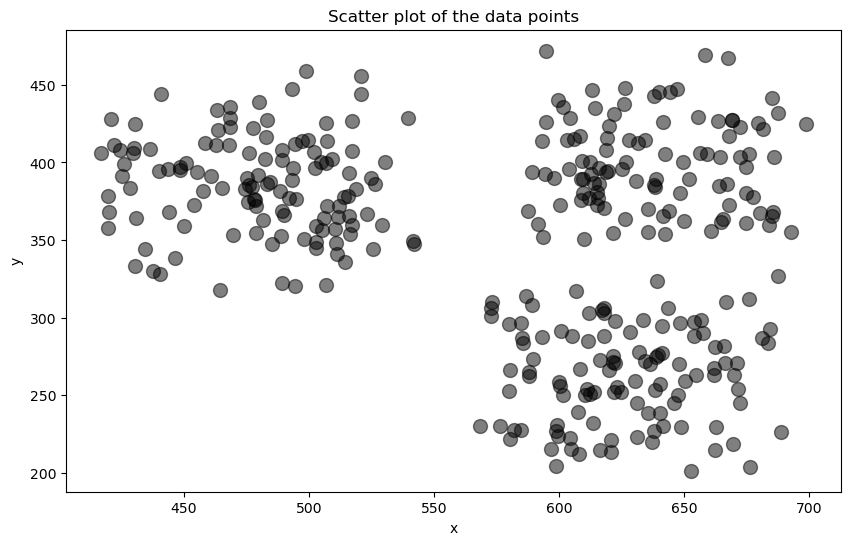

In [247]:
# Function to plot the data points of two features
def plot_data(data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data.columns[0]], data[data.columns[1]], s=100, c='black', alpha=0.5)
    plt.title('Scatter plot of the data points')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

# Ploting the data points of two features
plot_data(data)

### Estandarización de los datos

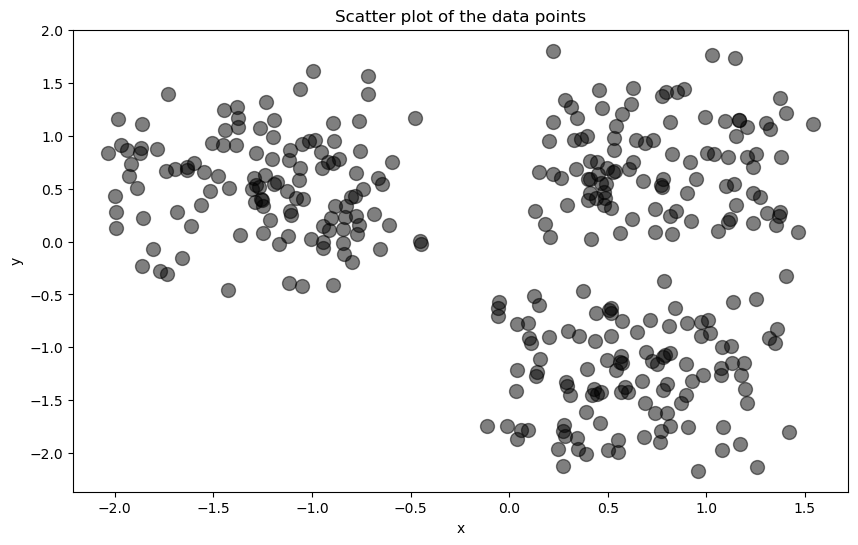

In [248]:
X = np.array(data)
standarized_data = StandardScaler().fit_transform(X=X)
standarized_df = pd.DataFrame(standarized_data, columns=data.columns)
plot_data(standarized_df)

## Método del codo

El método del codo o Elbow Method en inglés es utilizado para determinar el número óptimo de clusters en el que los datos pueden ser divididos.

In [249]:
# Code retrieved from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(standarized_data)
 
    distortions.append(sum(np.min(cdist(standarized_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / standarized_data.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(standarized_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / standarized_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

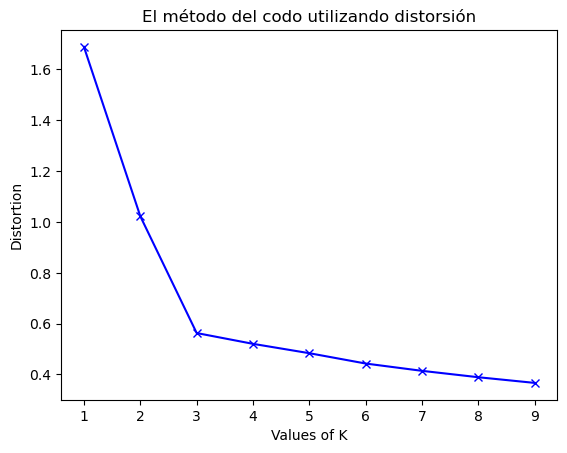

In [250]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('El método del codo utilizando distorsión')
plt.show()

## Implementación de K-means desde cero

### Inicialización de centroides

Uno de los primeros pasos para ejecutar el algoritmo de K-means es inicializar los centroides que no son más que puntos con $ d $ dimensiones que serán ubicados en el espacio de datos de manera aleatoria. Para ello procederemos a crear una matriz de dimensión $K \times d$ que contendrá los $ K $ centroides en donde cada fila representa un punto en la dimensión $d$.

In [251]:
# This value is obtained as a result of the elbow method
K = 3

# Assigning random points to each centroid from the standarized data
def assign_centroids(K, standarized_data):
    centroids_df = pd.DataFrame(standarized_df).sample(K)
    centroids = np.array(centroids_df)
    return centroids

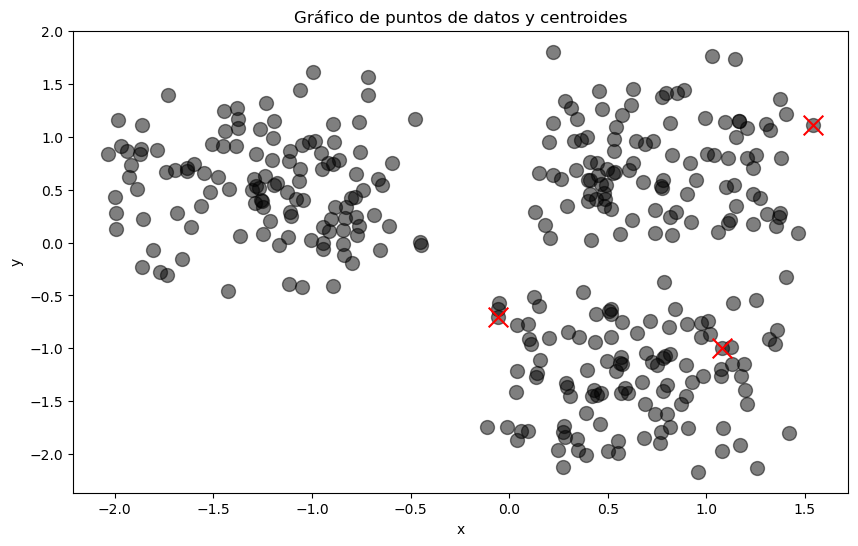

In [252]:
# Function to plot the data points of two features and the centroids
def plot_data_centroids(data, centroids):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data.columns[0]], data[data.columns[1]], s=100, c='black', alpha=0.5)
    plt.scatter(centroids[centroids.columns[0]], centroids[centroids.columns[1]], c='red', s=200, marker='x')
    plt.title('Gráfico de puntos de datos y centroides')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

# Ploting the data points of two features and the centroids
plot_data_centroids(standarized_df, pd.DataFrame(assign_centroids(K, standarized_data), columns=standarized_df.columns))

### Distancia euclidiana

Para encontrar la distancia entre dos puntos $(x_{1}^{(1)}, x_{2}^{(1)})$,  $(x_{1}^{(2)}, x_{2}^{(2)})$ en donde solo hay dos dimensiones: $x_{1}$ y $x_{2}$, esta se calcula de la siguiente manera: 

$$ 
    \sqrt{(x_{1}^{(1)} - x_{1}^{(2)})^2 + (x_{2}^{(1)} - x_{2}^{(2)})^2} 
$$

Si se le agregan más dimensiones a ambos puntos por igual la distancia euclídea podrá ser calculada de la siguiente manera:
$$
    \sqrt{\sum_{i = 1}^d{(punto1 - punto2)^2}}
$$

Dado de que en la vida real se utilizan $ d $ dimensiones para entrenar un modelo, el código para calcular la distancia euclídea se ha realizado tomando en cuenta las siguientes características 
* La función recibe dos vectores con dimensiones $1 \times d$
* Cada vector representa un punto con $ d $ dimensiones

In [253]:
# Function for obtaining the result of the euclidean distance between two matrices
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

### Algoritmo de K-means

Este consiste en lo siguiente:
* Se asignan $ k $ puntos de manera aleatoria entre los puntos de los datos, estos representan los centroides de los clusters.
* Se calcula la distancia de todos los puntos con cada uno de los centroides y se asigna cada punto al cluster del centroide más cercano.
* Se calcula el promedio de cada cluster y los centroides son actualizados con los promedios de cada cluster.
* Se repite el proceso anterior hasta que el valor de los centroides no cambie. Esto indica que el algoritmo ha convergido.

In [254]:
def kmeans_from_scratch(X, n_clusters, max_iters):
    print(len(X))
    distances = np.zeros((len(X), n_clusters))
    cluster_assignments = np.zeros(len(X), dtype=int)
    centroids = assign_centroids(n_clusters, X)
    new_centroids = np.zeros((n_clusters, len(X[0])))
    cluster_points = []

    for i in range(max_iters):

        # Assigning the X points to the closest centroid
        for i in range(len(X)): 
            for j in range(n_clusters): 
                distances[i][j] = euclidean_distance(X[i], centroids[j])
            cluster_assignments[i] = np.argmin(distances[i])

        # Creating clusters
        for i in range(n_clusters):
            for j in range(len(X)):
                if(cluster_assignments[j] == i):
                    cluster_points.append(X[j])
            # Updating the centroids
            new_centroids[i] = np.array(cluster_points).mean(axis=0)
            cluster_points = []

        centroids = new_centroids

        if(np.all(centroids == new_centroids)):
            break

    return centroids, cluster_assignments

336


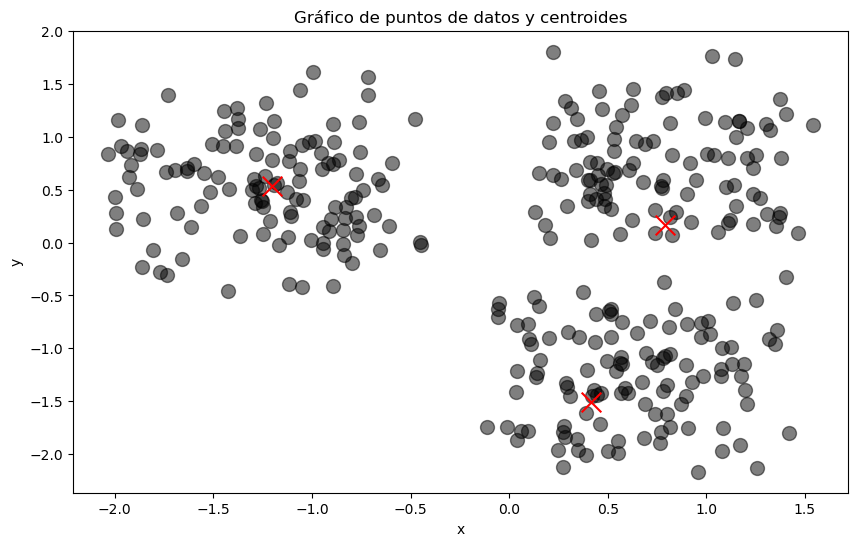

In [255]:
# Applying the K-means algorithm
centroids, labels = kmeans_from_scratch(standarized_data, K, 100000)
centroids_df = pd.DataFrame(centroids, columns=data.columns)

# Ploting the data points of two features and the centroids
plot_data_centroids(standarized_df, centroids_df)

### Evaluación del rendimiento

A continuación se ha desarrollado una función que se estará utilizando a lo largo del trabajo para poder visualizar el rendimiento del algoritmo a través de la silueta y su comportamiento con diferentes valores de $K$, es decir de clusters.

In [256]:
# Function to plot the data points, clusters and the silhouette score
def plot_silhoutte(range_n_clusters, X, model='', model_name='KMeans'):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = None
        cluster_labels = None
        if(model_name == 'KMeans' or model_name == 'KMedoids'):
            clusterer = model(n_clusters=n_clusters)
            cluster_labels = clusterer.fit_predict(X)
        elif(model_name == 'Agglomerative Clustering'):
            clusterer = model(n_clusters=n_clusters)
            cluster_labels = clusterer.fit_predict(X)
        else:
            clusterer, cluster_labels = kmeans_from_scratch(standarized_data, n_clusters, 100000)
             

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = metrics.silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        if model_name == 'KMeans' or model_name == 'KMedoids':
            centers = clusterer.cluster_centers_
        else:
            centers = clusterer
        # Draw white circles at cluster centers
        if(model_name != 'Agglomerative Clustering'):
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for {} clustering on sample data with n_clusters = %d".format(model_name)
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

336
For n_clusters = 2 The average silhouette_score is : 0.44973366846727103
336
For n_clusters = 3 The average silhouette_score is : 0.5094639933608982
336
For n_clusters = 4 The average silhouette_score is : 0.2967916001906352
336
For n_clusters = 5 The average silhouette_score is : 0.5269020016554594
336
For n_clusters = 6 The average silhouette_score is : 0.38738724899234844


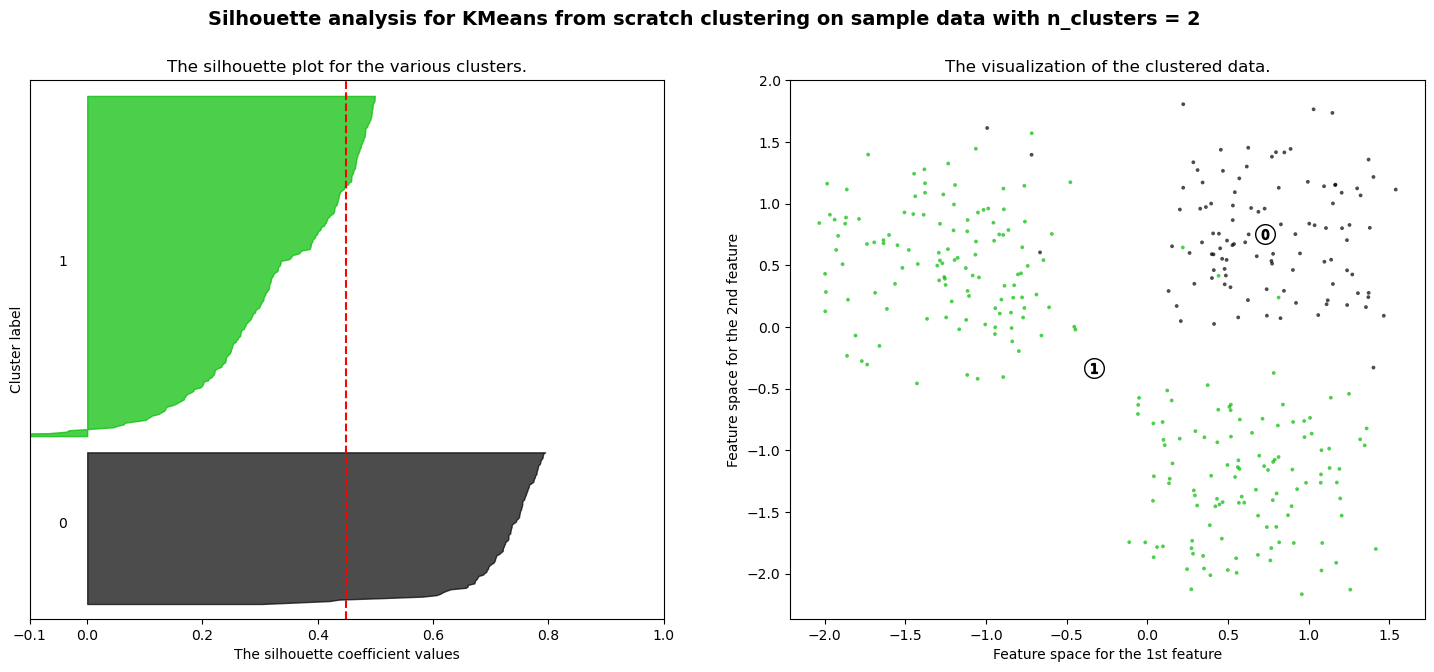

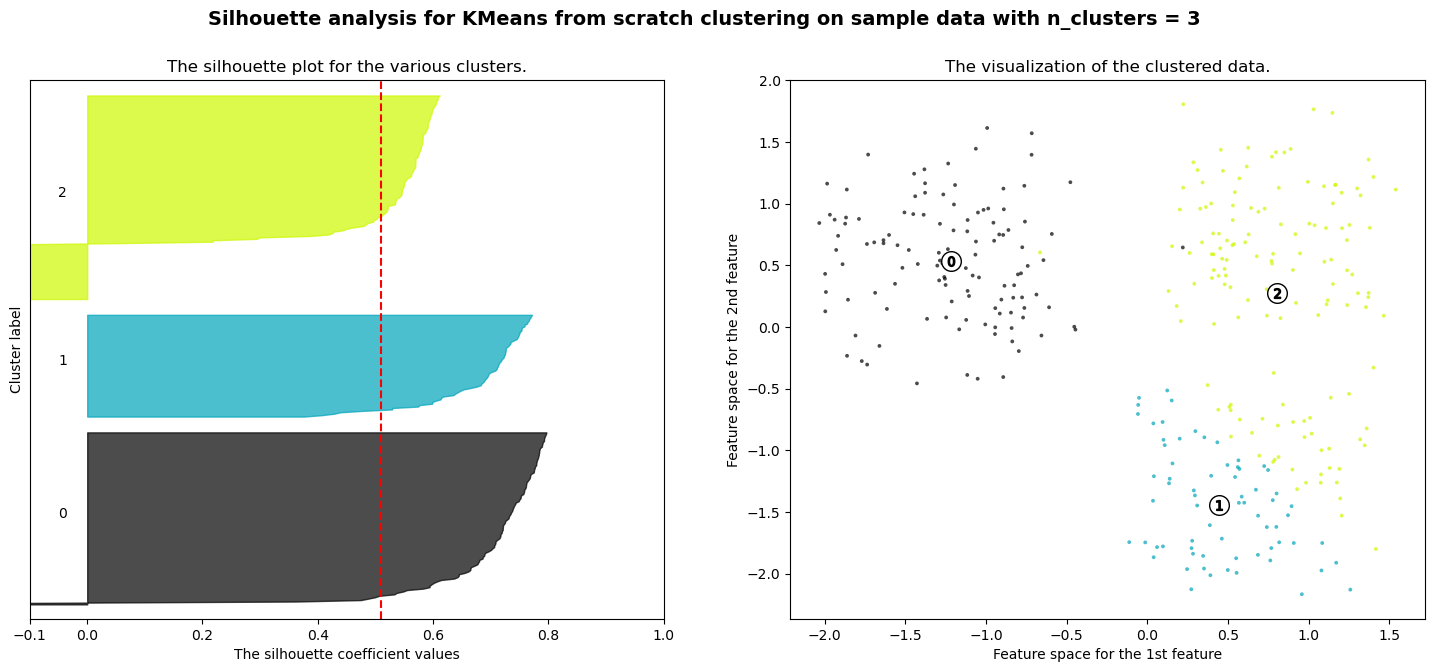

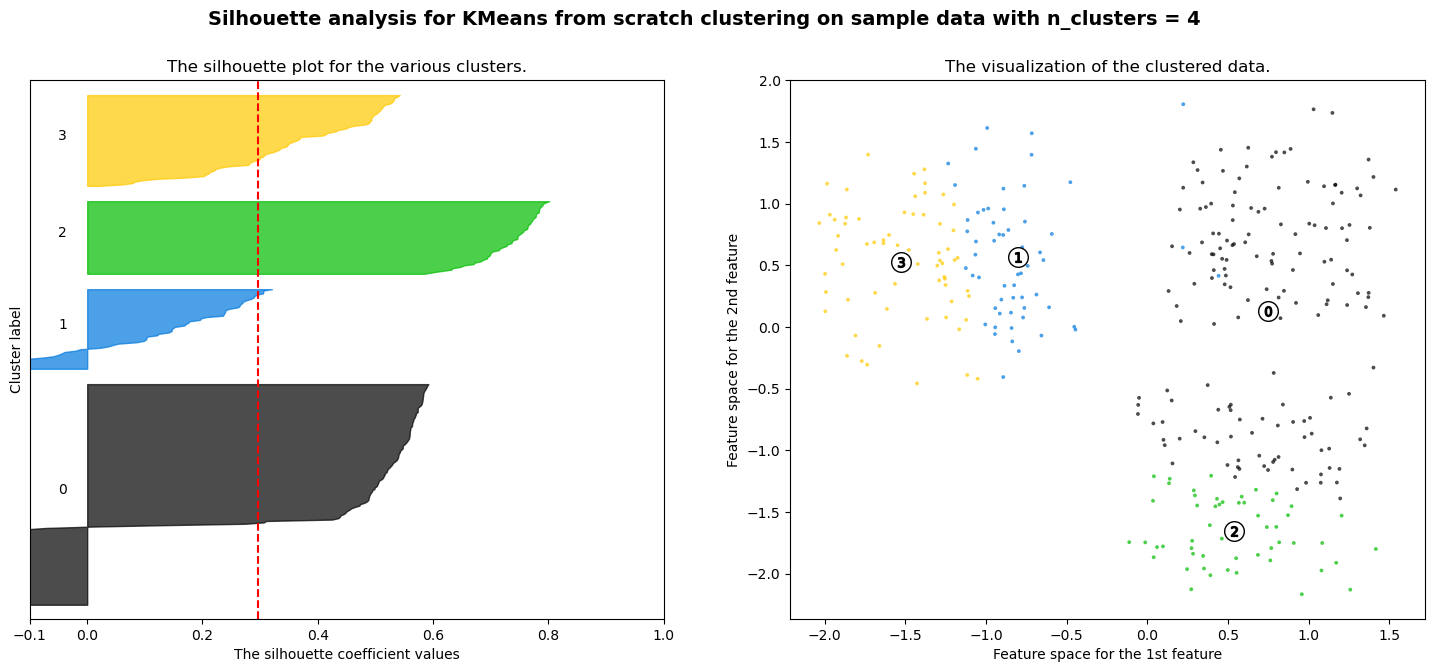

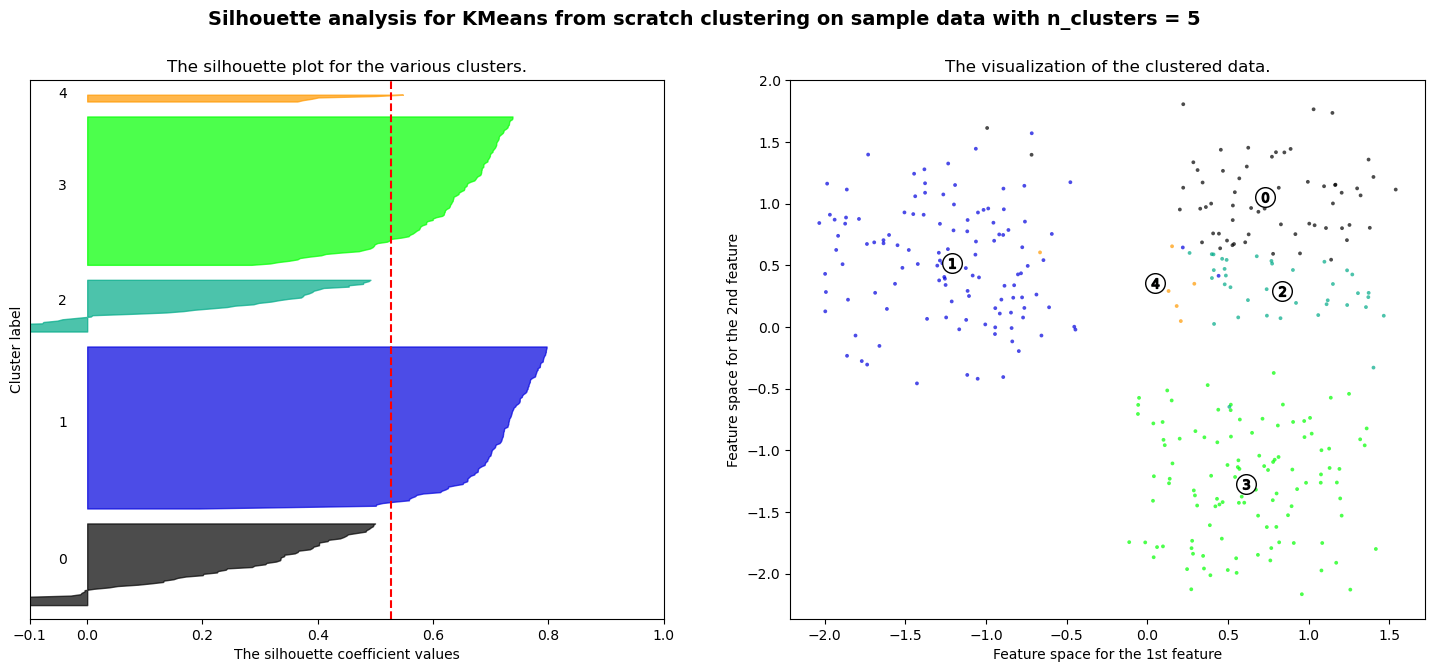

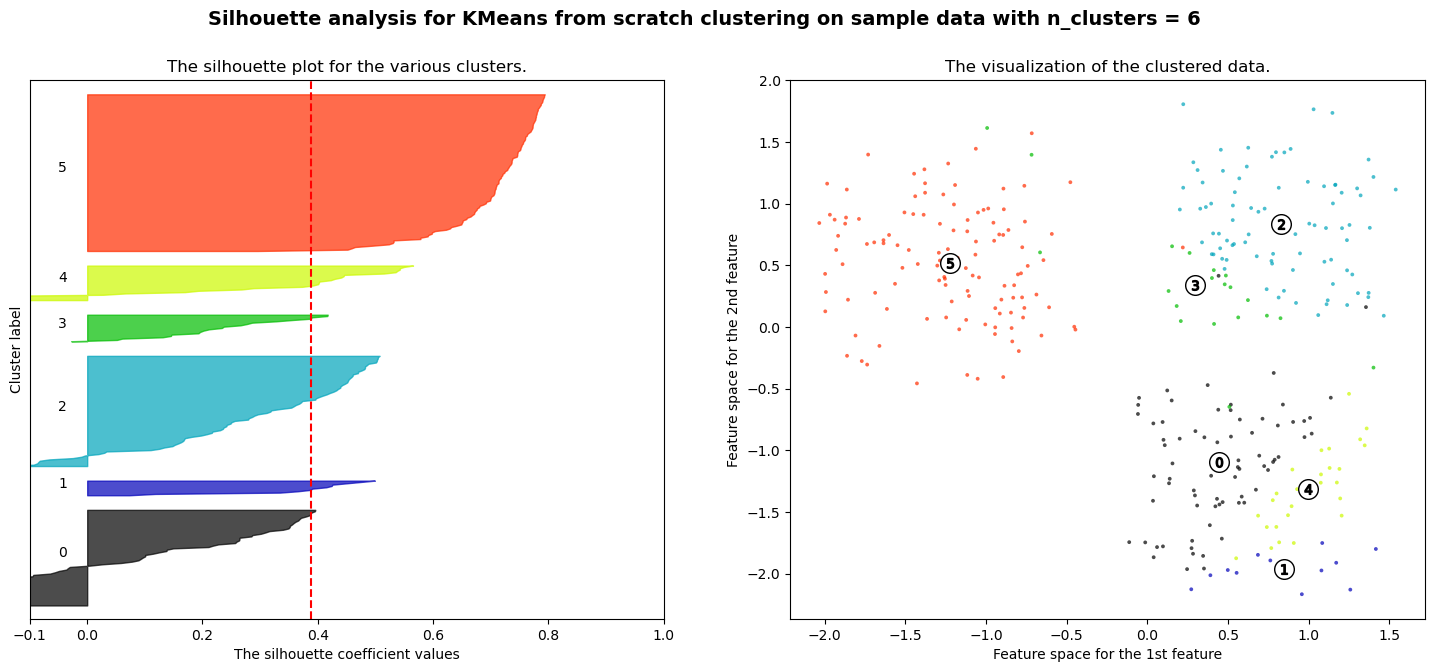

In [257]:
# Array of the range of clusters
range_n_clusters = [2, 3, 4, 5, 6]

plot_silhoutte(range_n_clusters, standarized_data, model_name='KMeans from scratch')

## Implementación de K-means con scikit-learn

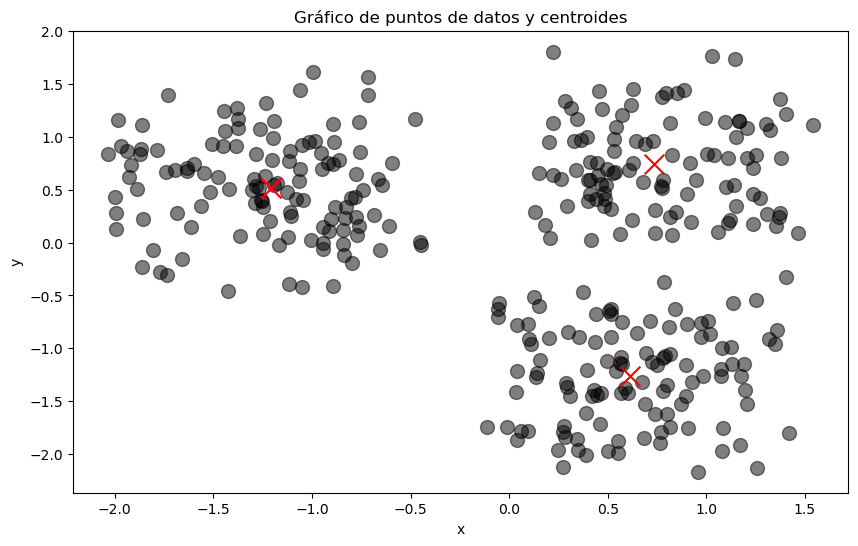

In [258]:
kmeans = KMeans(n_clusters=K, n_init='auto', max_iter=100000).fit(standarized_data)

plot_data_centroids(standarized_df, pd.DataFrame(kmeans.cluster_centers_, columns=data.columns))

### Evaluación del rendimiento

c:\Users\monic\anaconda3\envs\sklearn-extra-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\monic\anaconda3\envs\sklearn-extra-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\monic\anaconda3\envs\sklearn-extra-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\monic\anaconda3\envs\sklearn-extra-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

For n_clusters = 2 The average silhouette_score is : 0.5629166115517852
For n_clusters = 3 The average silhouette_score is : 0.683797978777321
For n_clusters = 4 The average silhouette_score is : 0.5503744680015514
For n_clusters = 5 The average silhouette_score is : 0.4353083089096665


c:\Users\monic\anaconda3\envs\sklearn-extra-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.3501249604358036


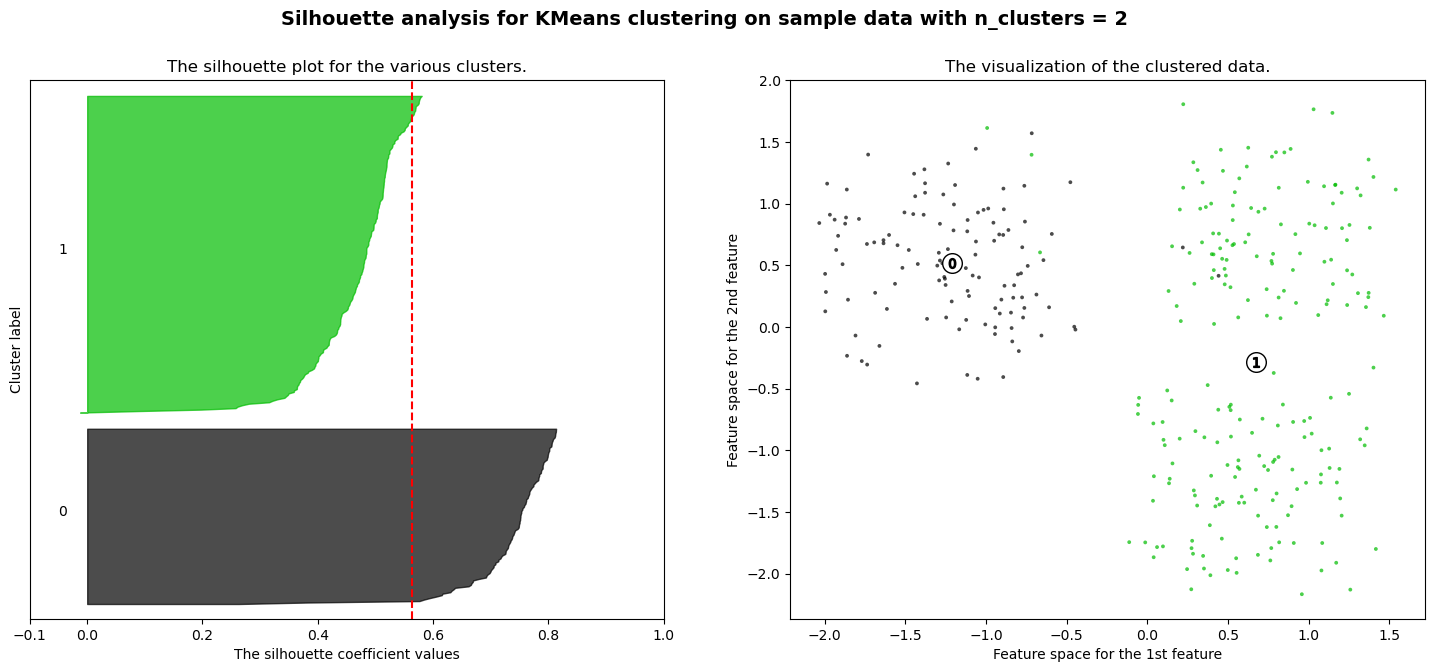

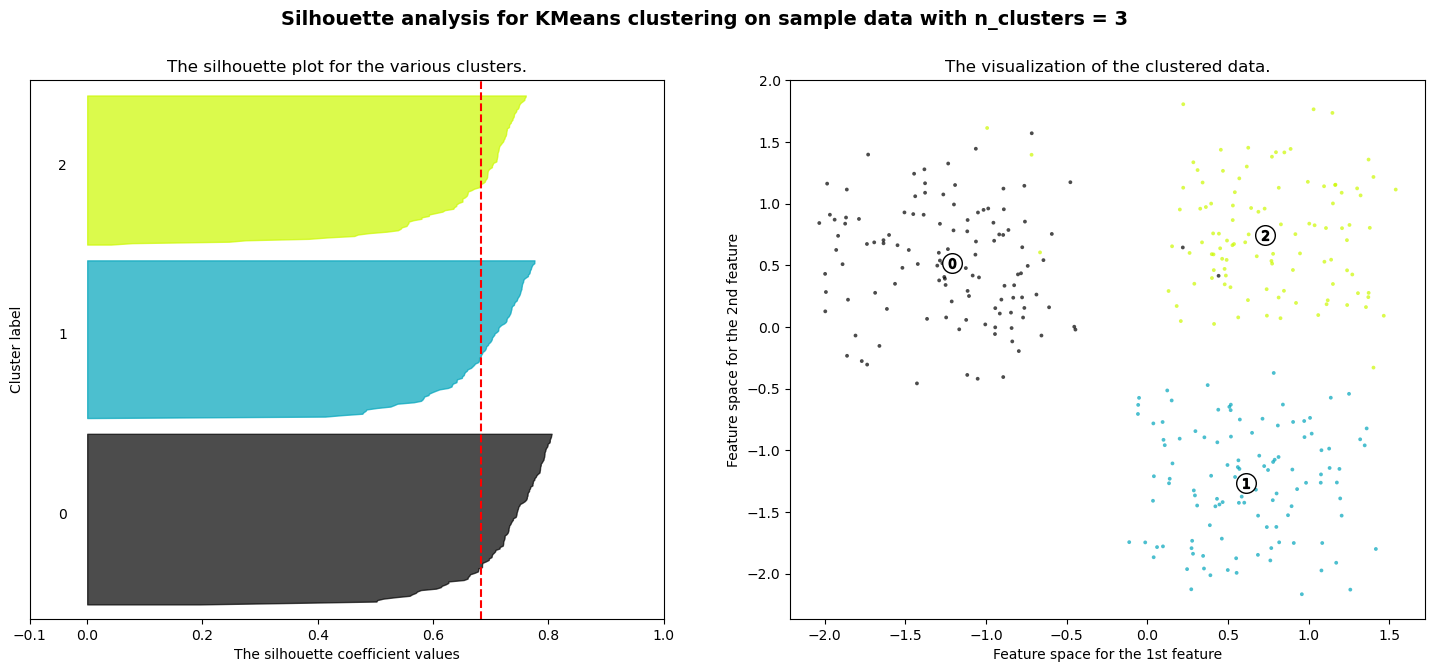

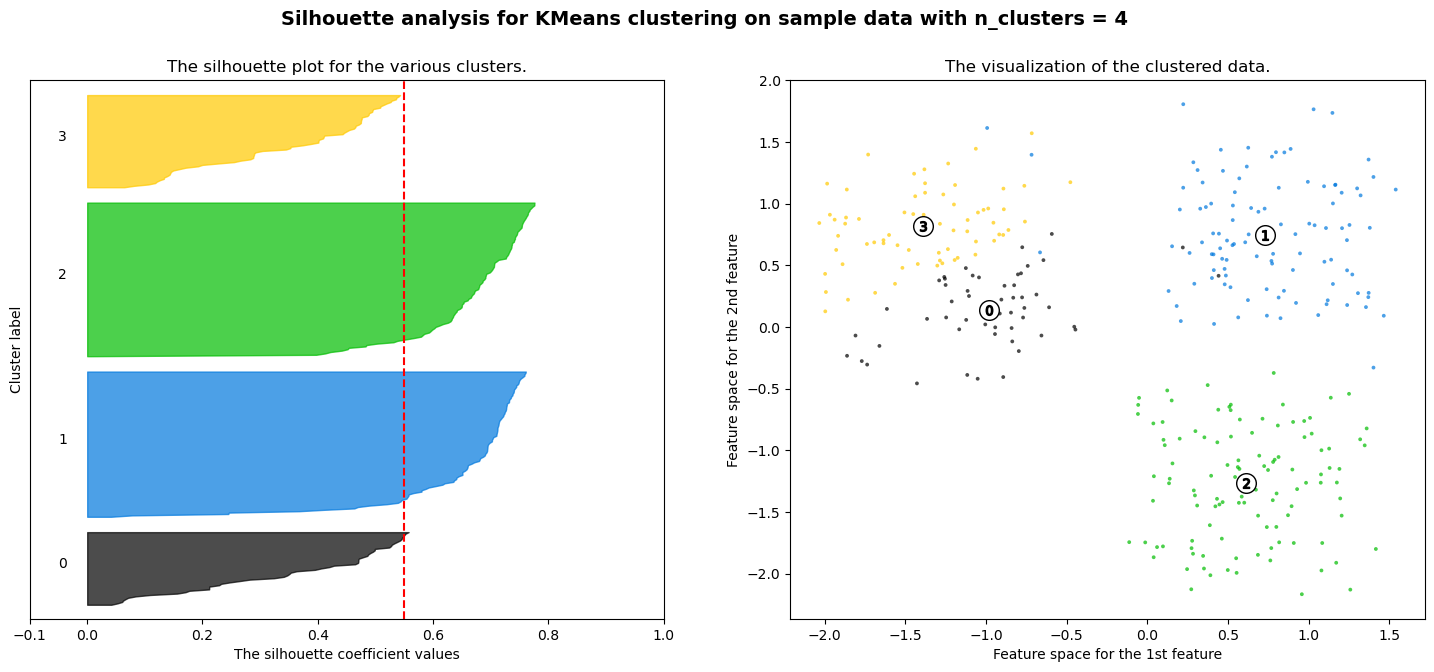

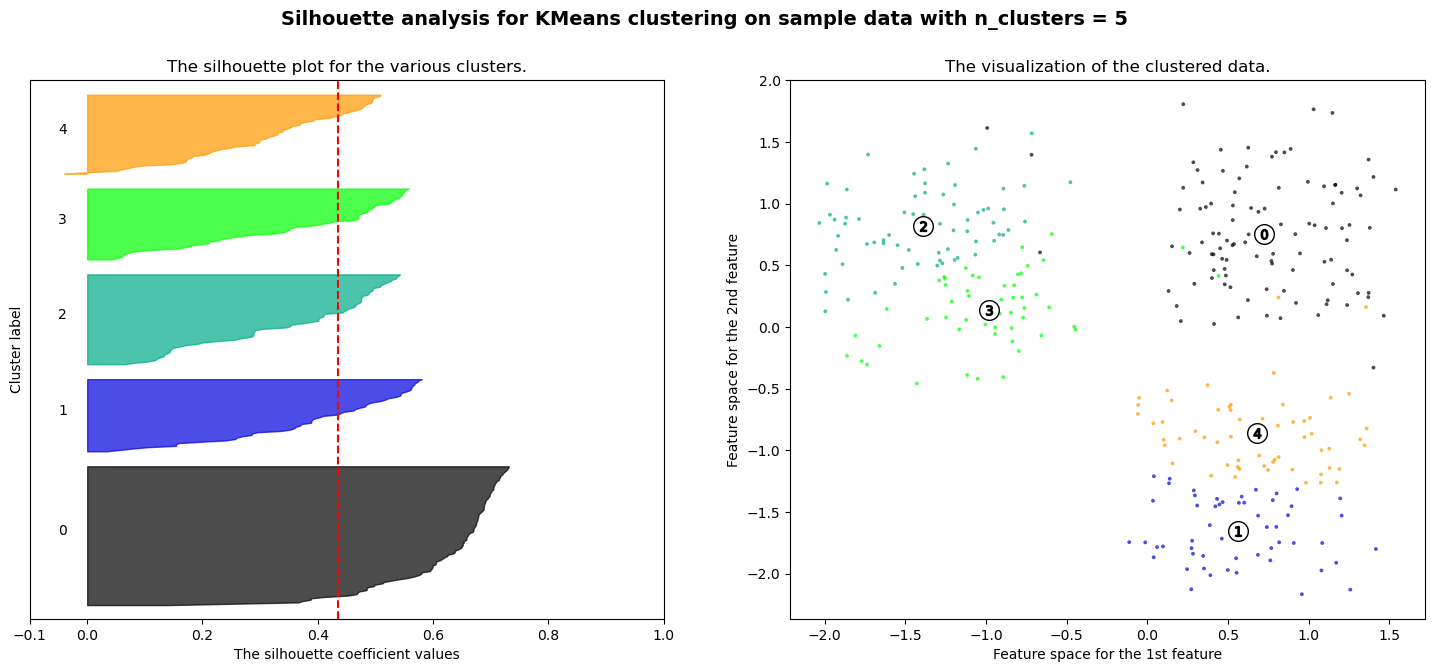

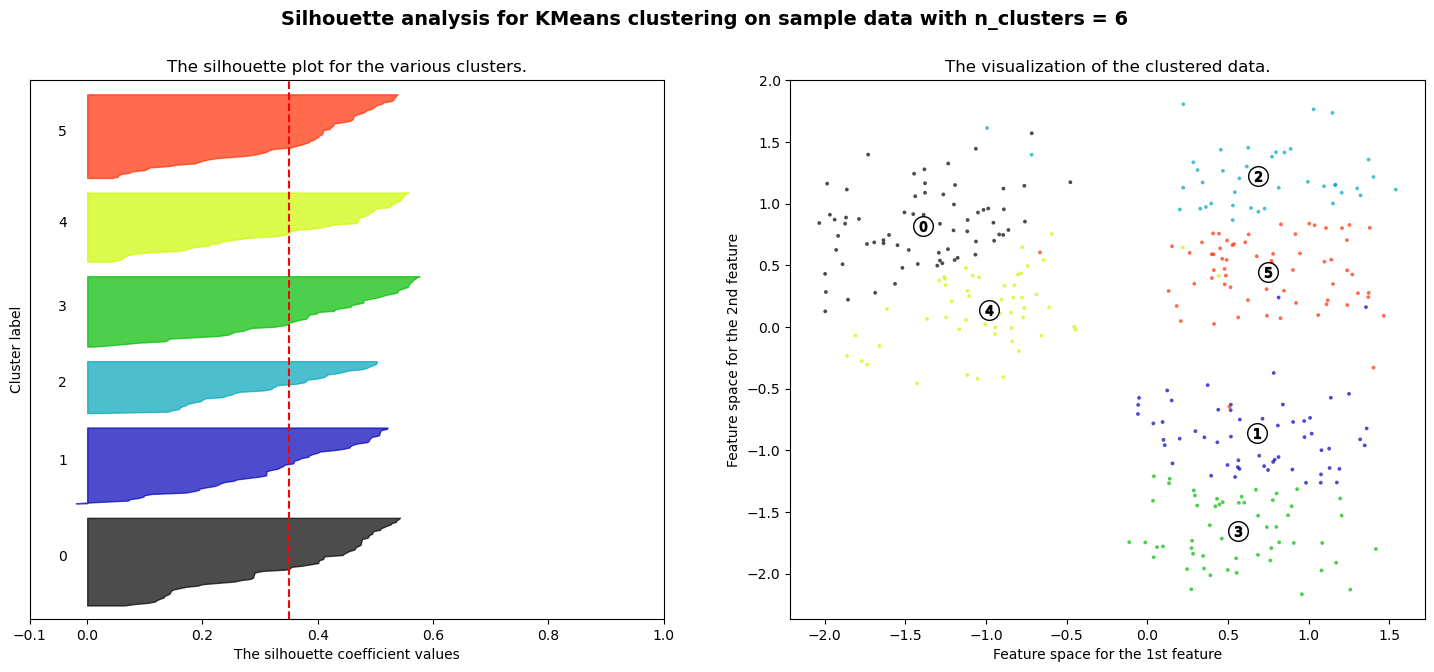

In [259]:
plot_silhoutte(range_n_clusters, standarized_data, model=KMeans, model_name='KMeans')

## K-medoids

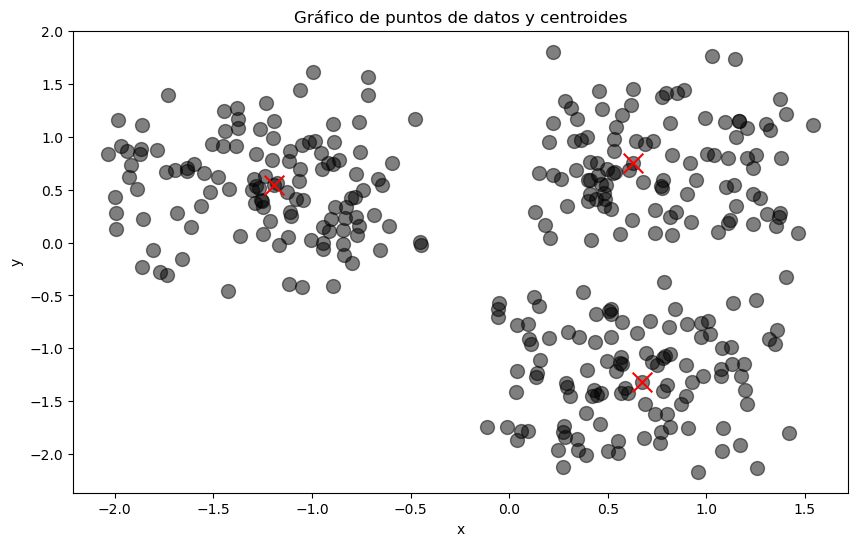

In [260]:
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(standarized_data)

plot_data_centroids(standarized_df, pd.DataFrame(kmedoids.cluster_centers_, columns=data.columns))

### Evaluación del rendimiento

For n_clusters = 2 The average silhouette_score is : 0.560290021026278
For n_clusters = 3 The average silhouette_score is : 0.6837633674267174
For n_clusters = 4 The average silhouette_score is : 0.5461179382218813
For n_clusters = 5 The average silhouette_score is : 0.5300035156753994
For n_clusters = 6 The average silhouette_score is : 0.5168395358935112


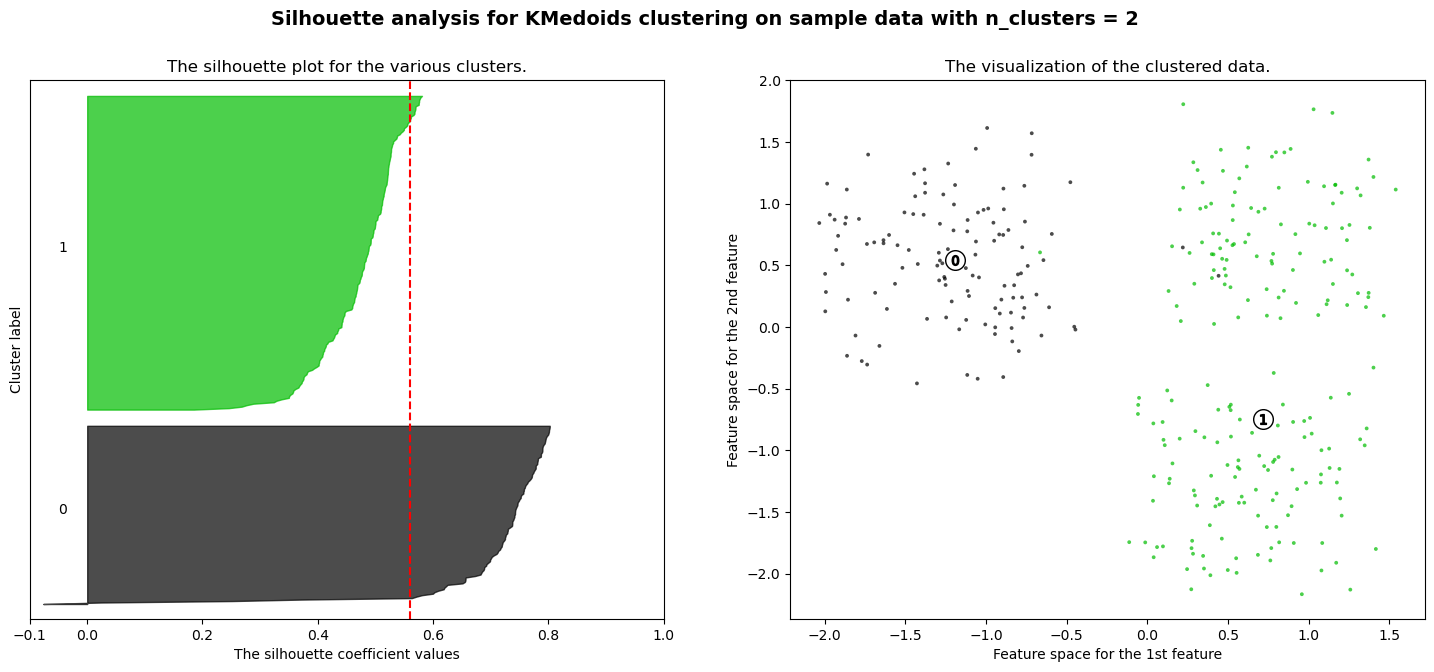

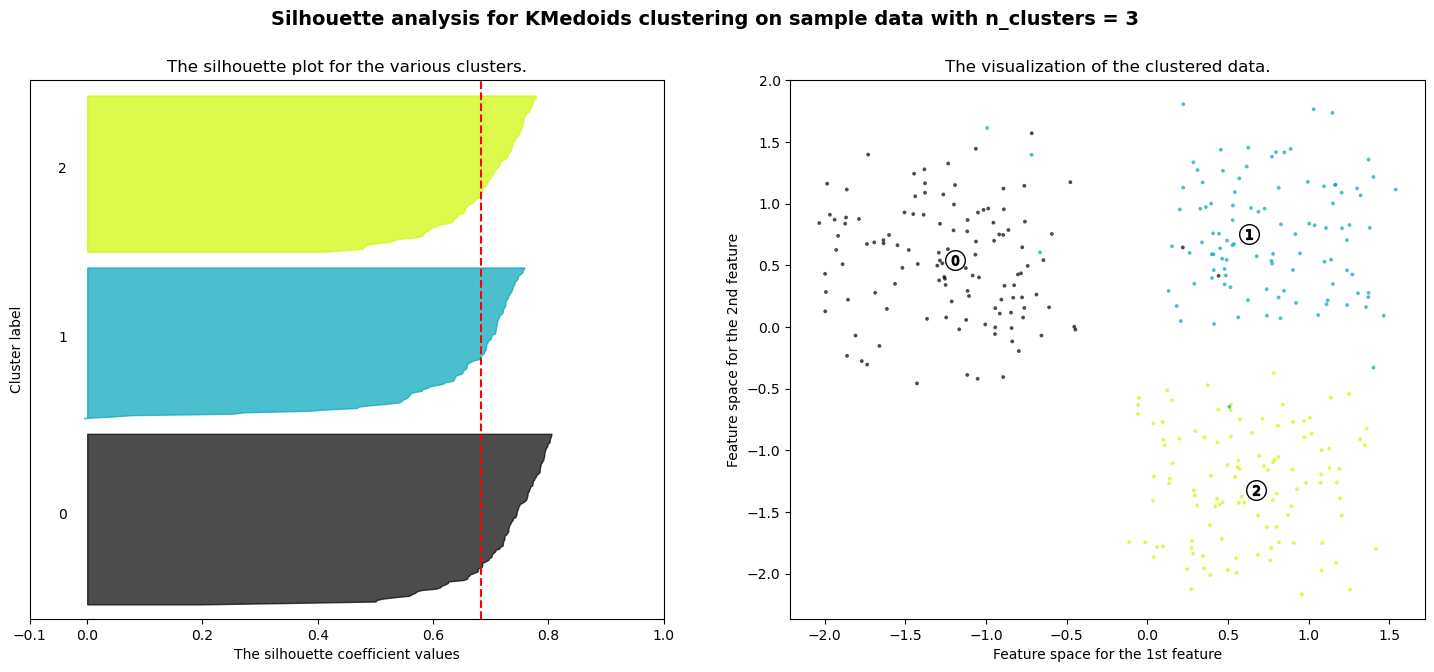

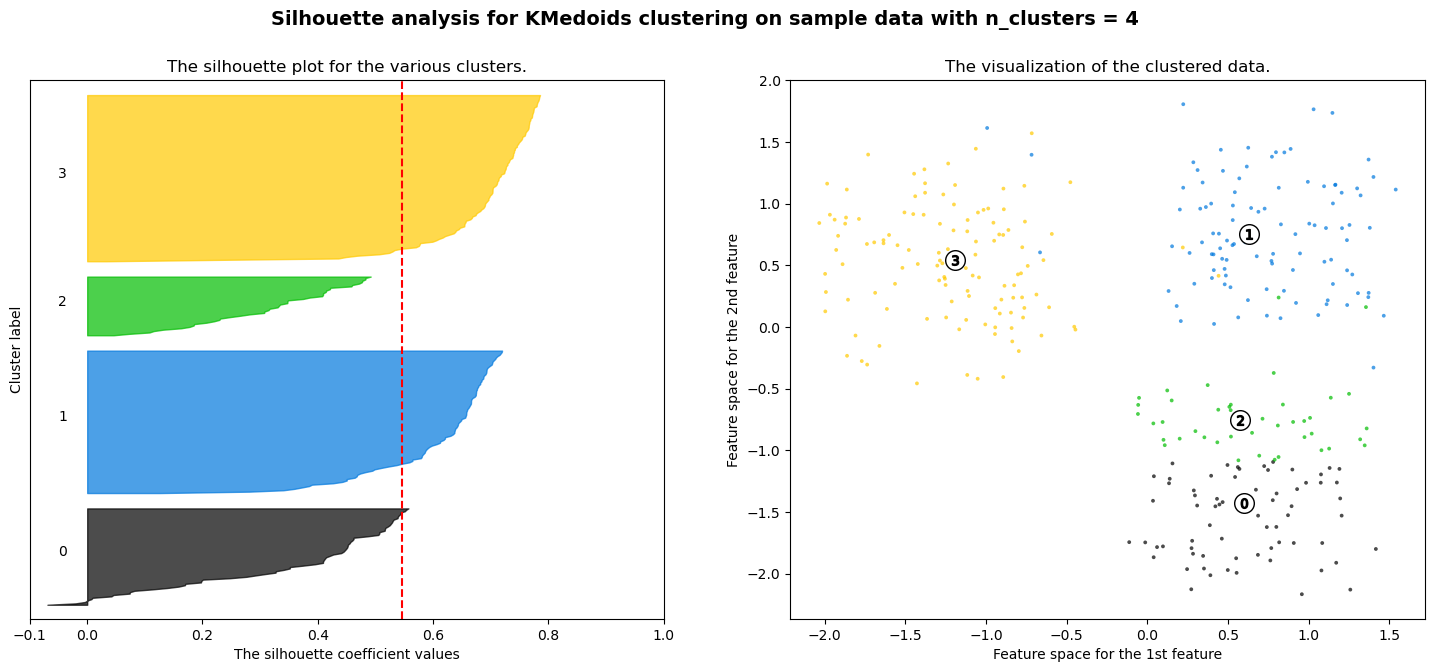

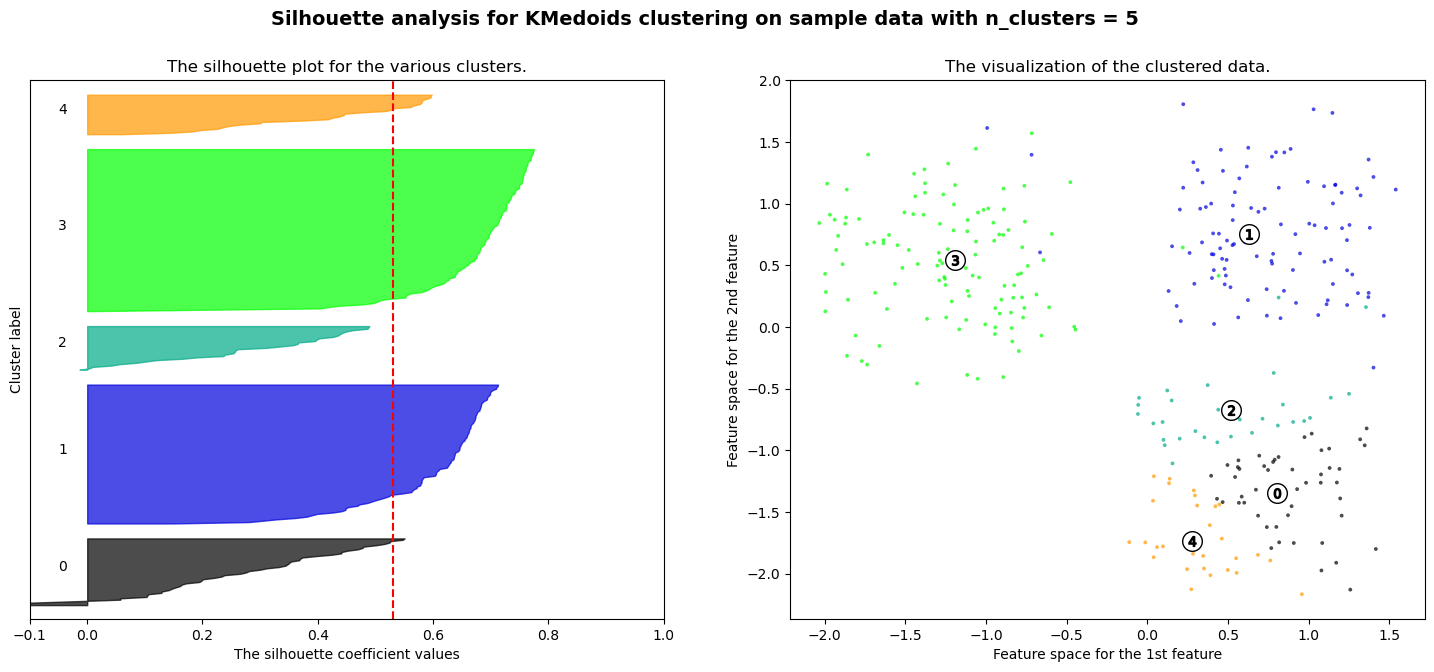

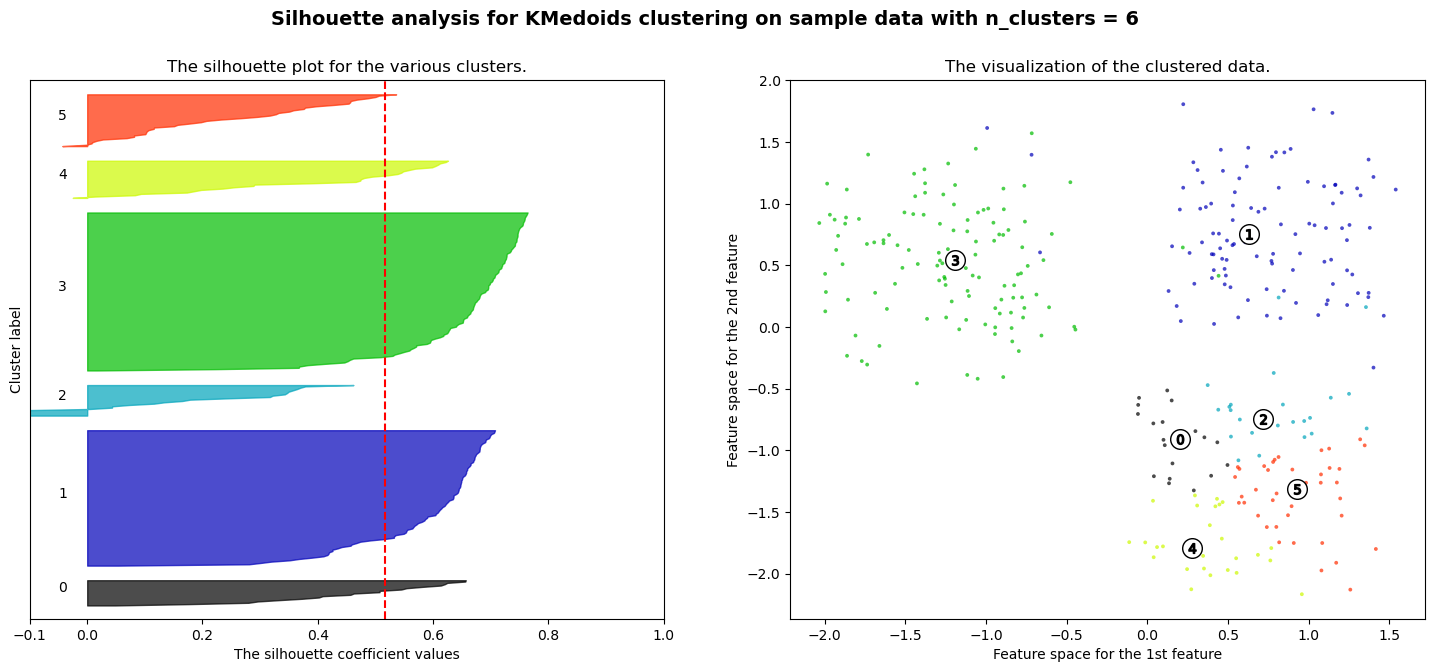

In [261]:
plot_silhoutte(range_n_clusters, standarized_data, model=KMedoids, model_name='KMedoids')

## Clustering Jerárquico

El clustering jerárquico es un método de agrupación de datos que organiza los puntos en una jerarquía de clusters (grupos). A diferencia de otros métodos de clustering como k-means, el clustering jerárquico no requiere que se especifique de antemano el número de clusters. 

En este caso de estudio se ha utilizado el aglomerativo (acumulativo) el cual se caracteriza por los siguientes puntos: 
* Comienza con cada punto de datos como un cluster individual.
* En cada paso, se combinan los clusters más cercanos hasta que todos los puntos de datos estén en un solo cluster.

In [262]:
hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(standarized_data)

In [263]:
# Code obtained from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

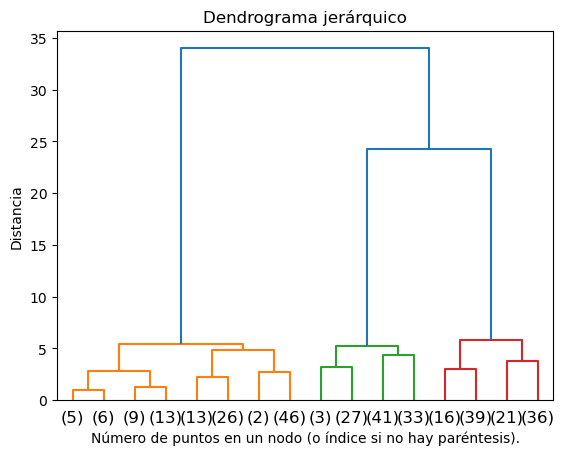

In [264]:
plt.title("Dendrograma jerárquico")
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchical, truncate_mode="level", p=3)
plt.xlabel("Número de puntos en un nodo (o índice si no hay paréntesis).")
plt.ylabel("Distancia")
plt.show()

### Evaluación del rendimiento

For n_clusters = 2 The average silhouette_score is : 0.5629166115517852
For n_clusters = 3 The average silhouette_score is : 0.6829029227377316
For n_clusters = 4 The average silhouette_score is : 0.550699452336438
For n_clusters = 5 The average silhouette_score is : 0.4136219143833892
For n_clusters = 6 The average silhouette_score is : 0.320524692421922


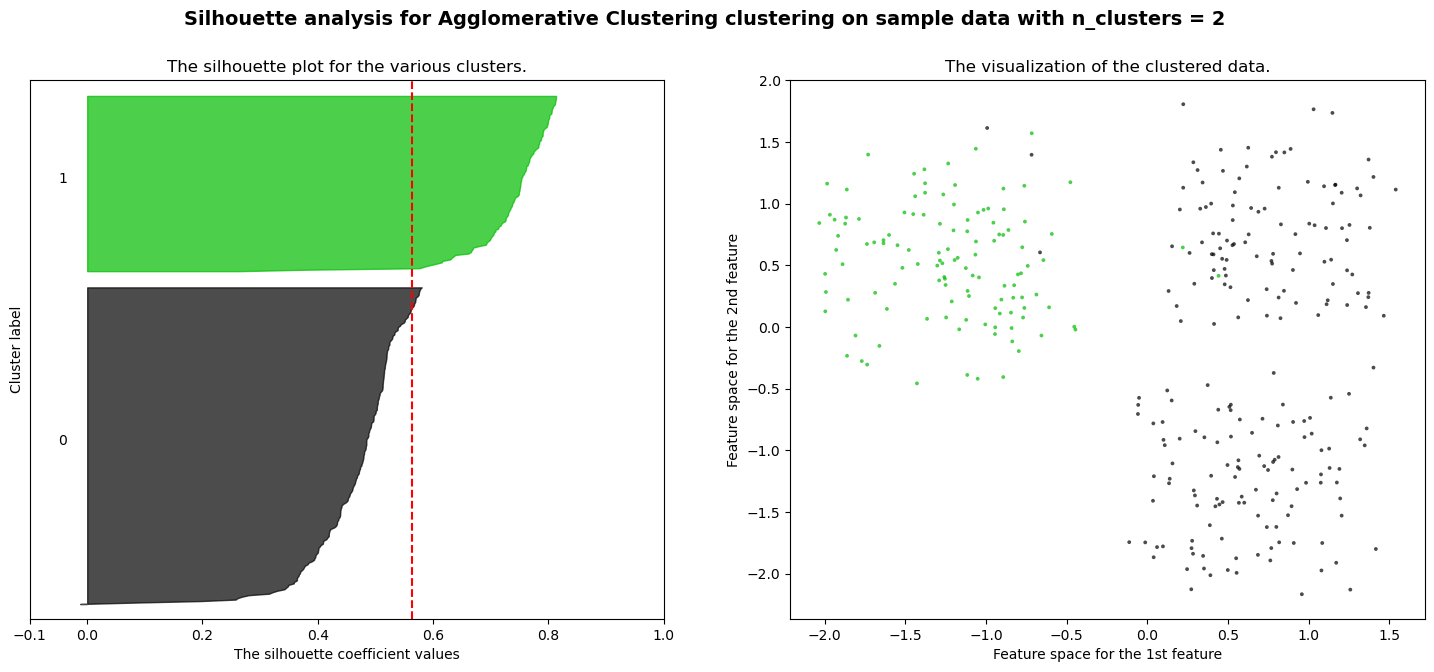

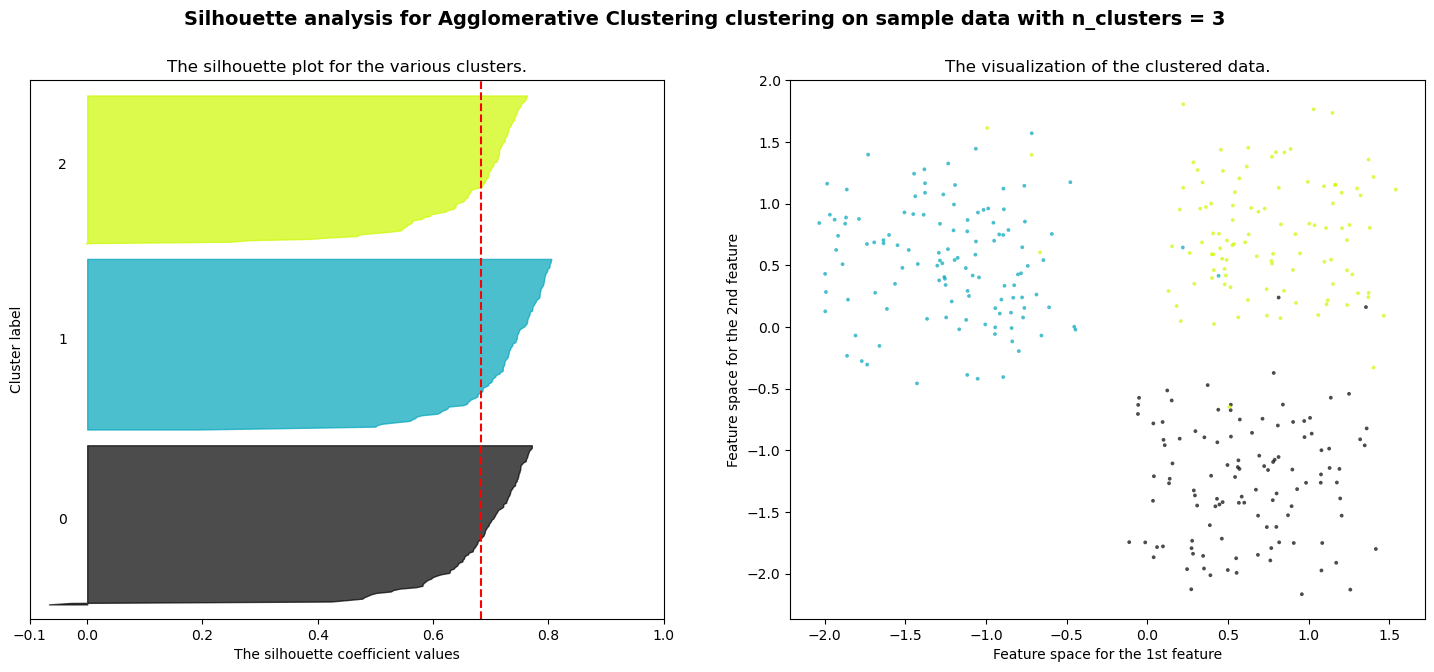

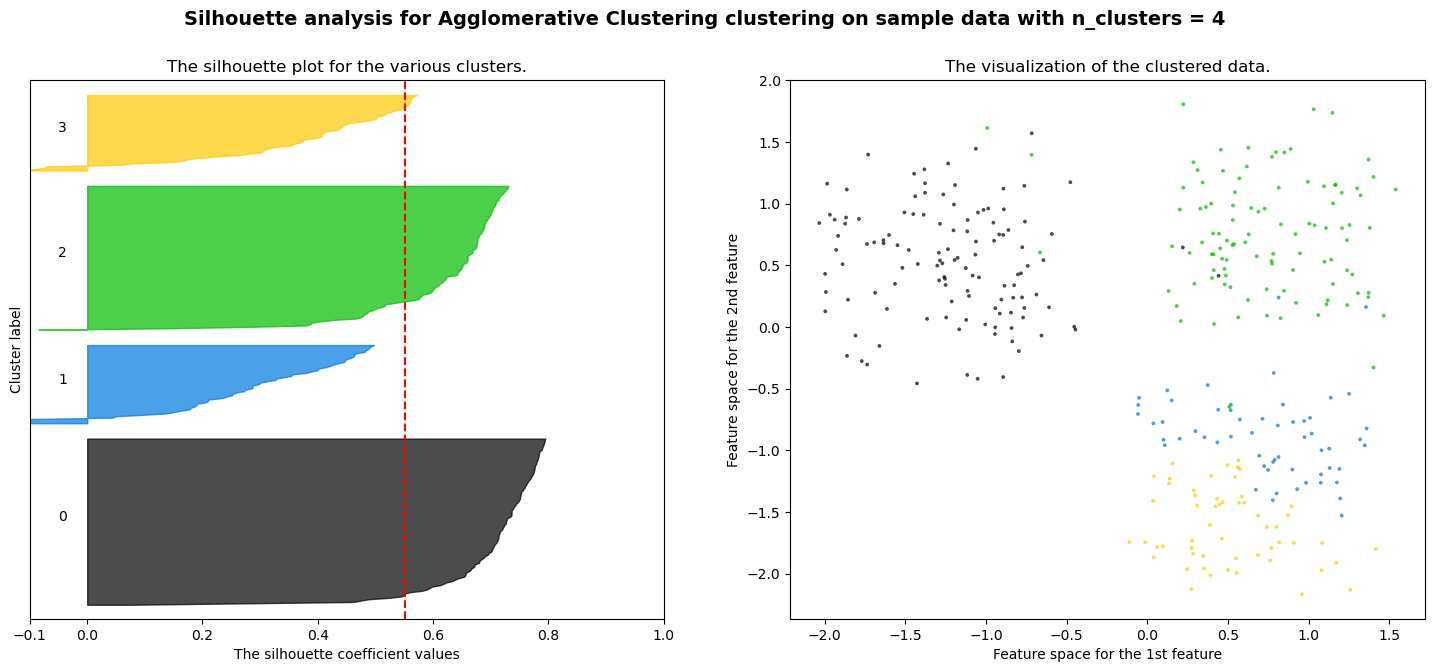

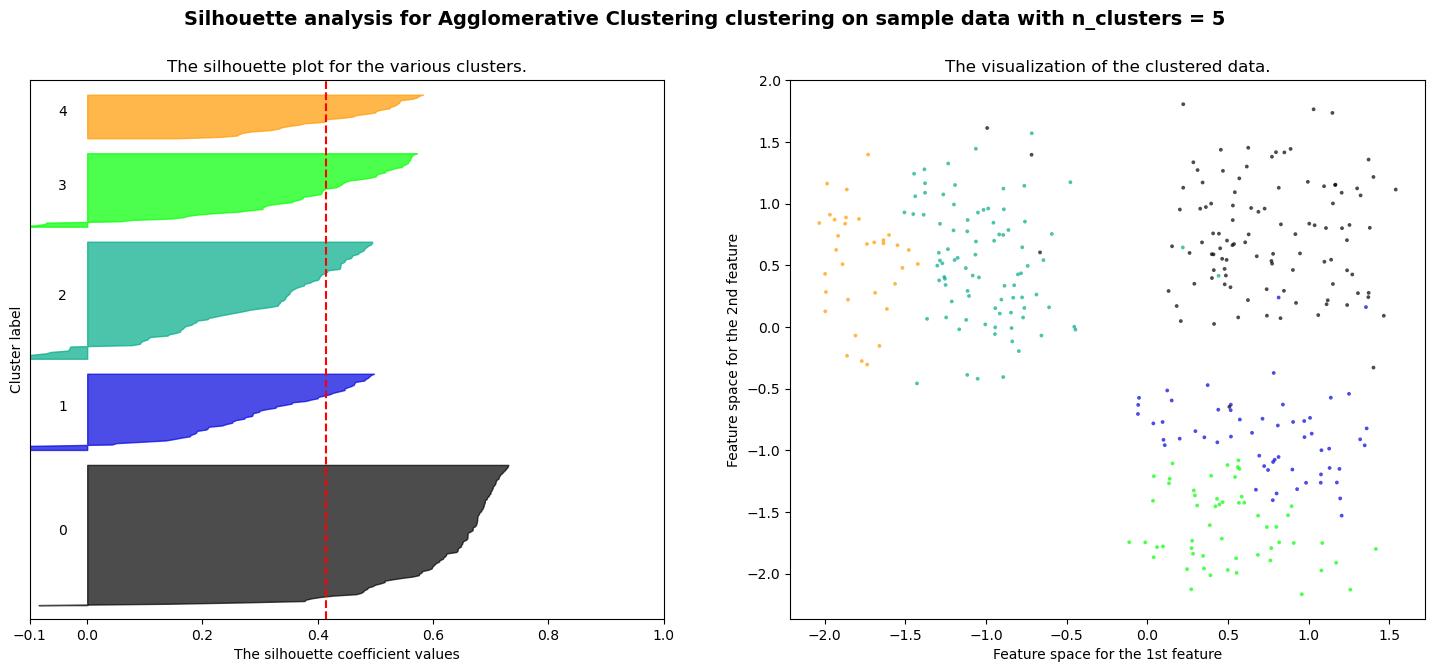

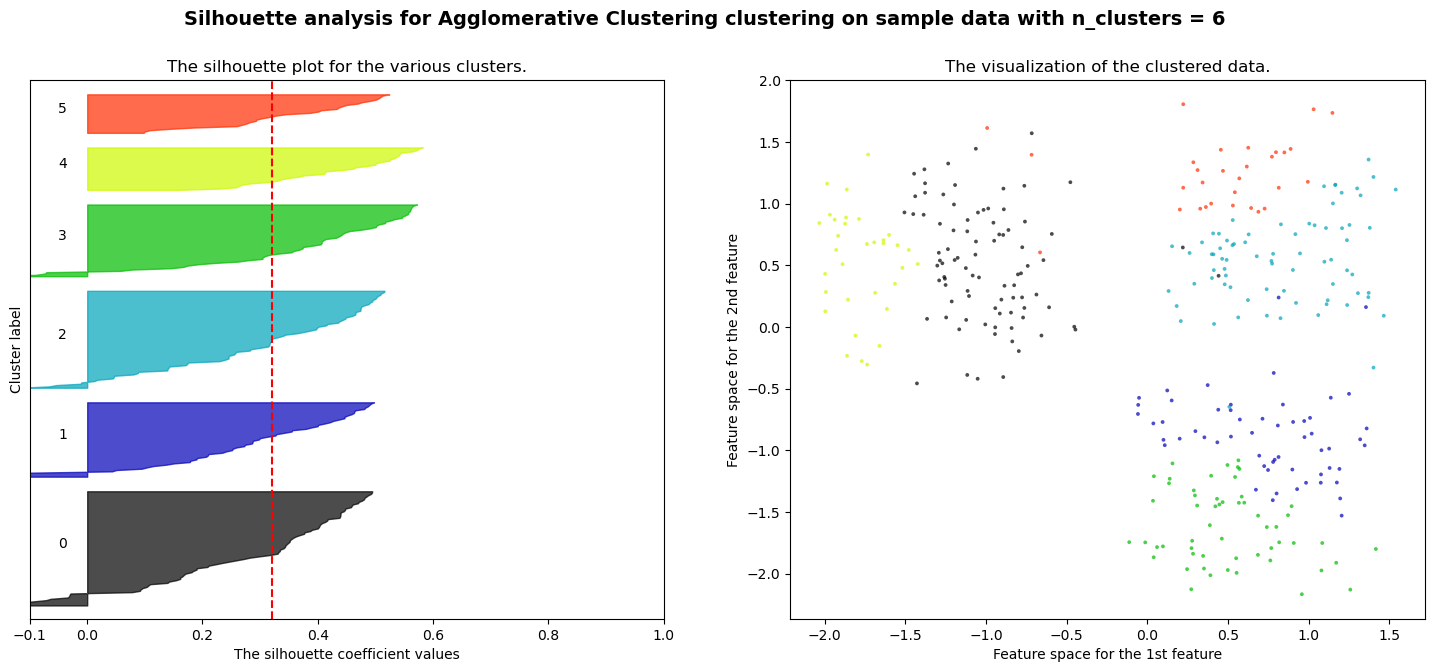

In [265]:
# Adjusting the model to the number of clusters desired
hierarchical = AgglomerativeClustering(n_clusters=3).fit(standarized_data)
labels = hierarchical.labels_

# Obtain the silhouette score
plot_silhoutte(range_n_clusters, standarized_data, model=AgglomerativeClustering, model_name='Agglomerative Clustering')

## Conclusiones

* Como se ha observado en la evaluación de rendimientos con la silueta para cada algoritmo, la implementación desde cero realizada en este trabajo es bastante sensible a la posición inicial de los centroides. Si los centroides se encuentran en posiciones lejanas a los clusters necesitarán de varias iteraciones para poder llegar a la posición óptima.
* La implementación de KMeans de la librería scikit-learn así como los demás algoritmos: KMedoids y Clustering Jerárquico se mantienen constantes en sus resultados y obtienen un promedio del coeficiente de la silueta por encima de 0.5 cuando se trata de 3 clusters en el dataset que se ha utilizado en este trabajo.
* Al comparar KMeans con KMedoids se ha identificado que la posición de los centroides con una misma cantidad de clusters es distinta en ambos modelos, esto debido a que en KMeans los centroides tienden a ubicarse en el promedio del cluster, y por otro lado, en KMedoids los centroides se ubican en el punto de los datos más cercano al promedio.

## Referencias

Theo Botella. Mayo de 2022. K-means clustering from scratch. Towards AI. 
    
    https://pub.towardsai.net/k-means-clustering-from-scratch-4e357ac4716f

GeeksforGeeks. 10 de Mayo de 2023. Elbow method for optimal value of K in KMeans. GeeksforGeeks. 
    
    https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

scikit-learn developers. s.f. Agglomerative clustering with and without structure: Example of generating a dendrogram. scikit-learn.
    
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html